In [4]:
%load_ext autoreload
%autoreload 2

# Select 2023-2024 NBA Season

In [54]:
import pandas as pd

matchups = pd.read_csv("data/all_games.csv")
matchups["WL_A"].replace("L", 0, inplace=True)
matchups["WL_A"].fillna(0, inplace=True)
matchups["WL_A"].replace("W", 1, inplace=True)

In [74]:
season_2023 = matchups[matchups["SEASON_ID"] == 22023]

testing_results = season_2023.sample(150)

In [73]:
def accuracy_array(prediction, actual_result):

    if prediction < 0.5:
        prediction = 0

    else:
        prediction = 1

    result_list = [prediction, actual_result]
    return result_list

In [58]:
from tensorflow.keras.models import model_from_json

json_file = open("tuned_nn.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("tuned.weights.h5")
# print("Loaded model from disk")

In [75]:
from api_helpers.three_step_pipeline import ThreeStepPipeline, Matchup_Regressor
import warnings
import joblib

warnings.filterwarnings('ignore')

scaler = joblib.load("scaler.bin")

all_results = []
print(testing_results.iterrows())

for _, matchup in testing_results.iterrows():
    matchup = matchup.to_frame().T
    matchup.drop("Unnamed: 0", axis=1, inplace=True)
    rfe = Matchup_Regressor(team_a_id=matchup["TEAM_ID_A"].values[0],team_b_id=matchup["TEAM_ID_B"].values[0])
    seasonal_stats = rfe.seasonal_team_matchup()

    game_stat = rfe.rfe.predict(seasonal_stats)

    game_stat = scaler.transform(game_stat)

    game_prediction = loaded_model.predict(game_stat)

    result_set = accuracy_array(game_prediction[0][0], matchup["WL_A"].values[0])

    all_results.append(result_set)


<generator object DataFrame.iterrows at 0x744f04db47b0>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms

In [76]:
import numpy as np
results_frame = pd.DataFrame(all_results, columns=["pred", "true"])

In [77]:
y_pred = results_frame["pred"]
y_true = results_frame["true"]

Best Neural Network classification report:
              precision    recall  f1-score   support

           0       0.42      0.47      0.44        73
           1       0.43      0.39      0.41        77

    accuracy                           0.43       150
   macro avg       0.43      0.43      0.43       150
weighted avg       0.43      0.43      0.43       150



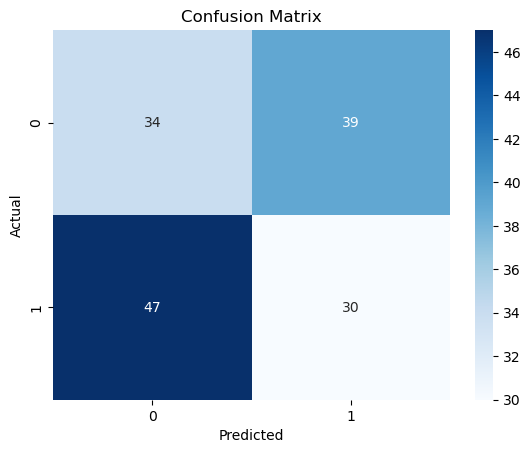

In [78]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model
print("Best Neural Network classification report:")
print(classification_report(y_pred, y_true))

# Confusion matrix
conf_matrix_nn = confusion_matrix(y_pred, y_true)
sns.heatmap(conf_matrix_nn, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()